# HW7: K-means Clustering and Principal Component Analysis

In this exercise, you will implement the K-means clustering algorithm and apply it to compress an image. In the second part, you will use principal component analysis to find a low-dimensional representation of face images. Before starting on the programming exercise, we strongly recommend watching the video lectures and completing the review questions for the associated topics.

In [1]:
import itertools as it
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as st
import scipy.misc
import scipy.optimize as op
import scipy.io
import random
from IPython.display import display, Math, Latex
 
# set path
import os
os.chdir('%s/courses/coursera_ml008/hw7' % os.getenv('DST'))
print(os.getcwd())

# printing options 
np.set_printoptions(linewidth=250)
np.set_printoptions(precision=3)

# plotting options
%matplotlib inline
plt.rc('font'  , size=18)
plt.rc('figure', figsize=(10, 8))
plt.rc('axes'  , labelsize=22)
plt.rc('legend', fontsize=16)
plt.rc('figure', figsize=(10, 8))

/Users/rwk7t/Development/dst/courses/coursera_ml008/hw7


## 1 K-means Clustering

In this this exercise, you will implement the K-means algorithm and use it for image compression. You will first start on an example 2D dataset that will help you gain an intuition of how the K-means algorithm works. After that, you wil use the K-means algorithm for image compression by reducing the number of colors that occur in an image to only those that are most common in that image. You will be using ex7.m for this part of the exercise.

### 1.1 Implementing K-means

The K-means algorithm is a method to automatically cluster similar data examples together. Concretely, you are given a training set $\{x^{(1)},\dots,x^{(m)}\}$ (where $x^{(i)} \in \Bbb{R}^n$), and want to group the data into a few cohesive “clusters”. The intuition behind K-means is an iterative procedure that starts by guessing the initial centroids, and then refines this guess by repeatedly assigning examples to their closest centroids and then recomputing the centroids based on the assignments.

The K-means algorithm is as follows (Octave/MATLAB):

```octave
% Initialize centroids
centroids = kMeansInitCentroids(X, K);
for iter = 1:iterations
    % Cluster assignment step: Assign each data point to the
    % closest centroid. idx(i) corresponds to cˆ(i), the index
    % of the centroid assigned to example i
    idx = findClosestCentroids(X, centroids);
    % Move centroid step: Compute means based on centroid
    % assignments
    centroids = computeMeans(X, idx, K);
end
```

The inner-loop of the algorithm repeatedly carries out two steps: (i) Assigning each training example x(i) to its closest centroid, and (ii) Recomputing the mean of each centroid using the points assigned to it. The K-means algorithm will always converge to some final set of means for the centroids. Note that the converged solution may not always be ideal and depends on the initial setting of the centroids. Therefore, in practice the K-means algorithm is usually run a few times with different random initializations. One way to choose between these different solutions from different random initializations is to choose the one with the lowest cost function value (distortion).

You will implement the two phases of the K-means algorithm separately in the next sections.

#### 1.1.1 Finding closest centroids

In the “cluster assignment” phase of the K-means algorithm, the algorithm assigns every training example $x^{(i)}$ to its closest centroid, given the current positions of centroids. Specifically, for every example i we set

\begin{align}
C^{(i)} := j \quad \text{that minimizes} \quad \| X^{(i)} - \mu_j\|^2
\end{align}

whre $C^{(i)}$ is the index of the centroid that is closest to $x^{(i)}$, and $\mu_j$ is the position (value) of the j-th centroid. Note that $C^{(i)}$ corresponds to `idx(i)` in the starter code.

Your task is to complete the code in `findClosestCentroids.m`. This function takes the data matrix X and the locations of all centroids inside centroids and should output a one-dimensional array idx that holds the index (a value in {1,...,K}, where K is total number of centroids) of the closest centroid to every training example.

You can implement this using a loop over every training example and every centroid. Once you have completed the code in `findClosestCentroids.m`, the script `ex7.m` will run your code and you should see the output `[1 3 2]` (or `[0 2 1]` in Python) corresponding to the centroid assignments for the first 3 examples.

##### load data

In [2]:
ex7data2 = scipy.io.loadmat('ex7data2.mat')
ex7data2.keys()

['X', '__version__', '__header__', '__globals__']

In [3]:
X = ex7data2['X']
X.shape

(300, 2)

In [4]:
def find_closest_centroids(X, centroids):
    
    from numpy.linalg import norm
    
    m, n = X.shape
    K    = centroids.shape[0]
    idxs = np.empty((m,), dtype=np.short)
        
    for i in np.arange(m):
        d       = norm(centroids - X[i,...], axis=1)
        idxs[i] = np.argmin(d)
             
    return idxs

##### test it

In [5]:
initial_centroids = np.array([[3,3], [6,2], [8,5]])
find_closest_centroids(X[0:3], initial_centroids)

array([0, 2, 1], dtype=int16)

#### 1.1.2 Computing Centroid means

Given assignments of every point to a centroid, the second phase of the algorithm recomputes, for each centroid, the mean of the points that were assigned to it. Specifically, for every centroid k we set

\begin{align}
\mu_k := \frac{1}{|C_k|}\sum_{i \in C_k} x^{(i)}
\end{align}

where $C_k$ is the set of examples that are assigned to centroid k. Concretely, if two examples say $x^{(3)}$ and $x^{(5)}$ are assigned to centroid $k = 2$, then you should update $\mu_2 = \frac{1}{2}(x^{(3)} + x^{(5)})$.

You should now complete the code in `computeCentroids.m`. You can implement this function using a loop over the centroids. You can also use a loop over the examples; but if you can use a vectorized implementation that does not use such a loop, your code may run faster.

Once you have completed the code in `computeCentroids.m`, the script `ex7.m` will run your code and output the centroids after the first step of K-means.

In [6]:
def compute_centroids(X, idxs, K):
    m, n      = X.shape
    centroids = np.empty((K,n))
    for k in np.arange(K):
        centroids[k,...] = np.mean(X[idxs==k], axis=0)
    return centroids  

##### test it

In [7]:
K       = 3
m       = 5
X_small = X[0:m]
X_small

array([[ 1.842,  4.608],
       [ 5.659,  4.8  ],
       [ 6.353,  3.291],
       [ 2.904,  4.612],
       [ 3.232,  4.94 ]])

In [8]:
idxs = find_closest_centroids(X_small, initial_centroids)
idxs

array([0, 2, 1, 0, 0], dtype=int16)

In [9]:
np.mean(X_small[idxs==0], axis=0)

array([ 2.659,  4.72 ])

In [10]:
compute_centroids(X_small, idxs, K)

array([[ 2.659,  4.72 ],
       [ 6.353,  3.291],
       [ 5.659,  4.8  ]])

In [11]:
compute_centroids(X, idxs, K)

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:5: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 300 but corresponding boolean dimension is 5


array([[ 2.659,  4.72 ],
       [ 6.353,  3.291],
       [ 5.659,  4.8  ]])

### 1.2 K-means on example dataset

<img src="fig1.png" width=500/>

After you have completed the two functions (`findClosestCentroids` and `computeCentroids`), the next step in `ex7.m` will run the K-means algorithm on a toy 2D dataset to help you understand how K-means works. Your functions are called from inside the `runKmeans.m` script. We encourage you to take a look at the function to understand how it works. Notice that the code calls the two functions you implemented in a loop. When you run the next step, the K-means code will produce a visualiza- tion that steps you through the progress of the algorithm at each iteration. Press enter multiple times to see how each step of the K-means algorithm changes the centroids and cluster assignments. At the end, your figure should look as the one displayed in Figure 1.

In [12]:
def plot_progress_means(ax, X, centroids, previous, idxs, i):
    import matplotlib.cm as cm
    colors = ['red', 'blue', 'green']
    K      = centroids.shape[0]
    for k in np.arange(K):
        mask = (idxs==k)
        ax.scatter(
            X[mask,0], 
            X[mask,1], 
            marker='o', 
            s=30, 
            alpha=0.3,
            linewidth=2,
            color='w',
            edgecolor=colors[k],
        )
            
    for k in np.arange(K):
        p1 = centroids[k,:]
        p2 = previous[k,:]
        ax.plot(
            (p1[0],p2[0]), 
            (p1[1],p2[1]), 
            'kx-',
            markersize=10, 
            linewidth=2, 
            markeredgewidth=2,
#             color=colors[k]
        )    
            
#plot_progress_means(plt, X, compute_centroids(X, idxs, K), compute_centroids(X, idxs, K)-1.0, idxs, 0)

In [13]:
def run_kmeans(X, initial_centroids, max_iters, display_progress=False):
    
    if display_progress:
        fig, ax = plt.subplots(figsize=(8, 8))
        plt.grid()

    m, n               = X.shape
    K                  = initial_centroids.shape[0]
    centroids          = initial_centroids
    previous_centroids = centroids
    
    for i in np.arange(max_iters):
        print("K-Means iteration %d/%d..."%(i, max_iters))
        idxs = find_closest_centroids(X, centroids)
        
        if display_progress:
            plot_progress_means(ax, X, centroids, previous_centroids, idxs, i)
            previous_centroids = centroids.copy()
                        
        centroids = compute_centroids(X, idxs, K)
            
    if display_progress:
        plt.show()
        
    return centroids, idxs

K-Means iteration 0/10...
K-Means iteration 1/10...
K-Means iteration 2/10...
K-Means iteration 3/10...
K-Means iteration 4/10...
K-Means iteration 5/10...
K-Means iteration 6/10...
K-Means iteration 7/10...
K-Means iteration 8/10...
K-Means iteration 9/10...


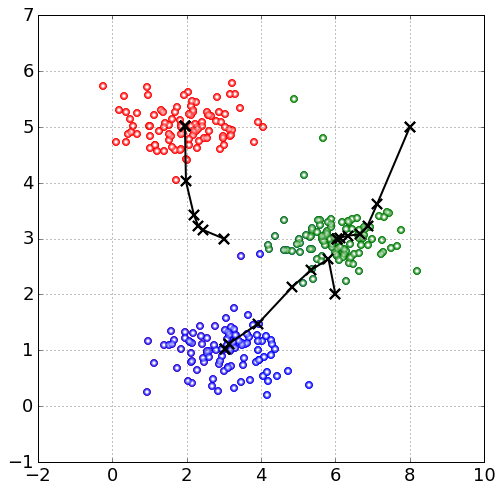

In [14]:
run_kmeans(X, initial_centroids, max_iters=10, display_progress=True)
plt.show()

### 1.3 Random Initialization

The initial assignments of centroids for the example dataset in `ex7.m` were designed so that you will see the same figure as in `Figure 1`. In practice, a good strategy for initializing the centroids is to select random examples from the training set.

In this part of the exercise, you should complete the function `kMeansInitCentroids.m` with the following code:

```octave
% Initialize the centroids to be random examples
% Randomly reorder the indices of examples
randidx = randperm(size(X, 1));
% Take the first K examples as centroids
centroids = X(randidx(1:K), :);
```

The code above first randomly permutes the indices of the examples (using randperm). Then, it selects the first K examples based on the random permutation of the indices. This allows the examples to be selected at random without the risk of selecting the same example twice.

In [15]:
def init_centroids_kmeans(X, K, seed=1):
    np.random.seed(seed)
    m, n      = X.shape
    rand_idx  = np.random.permutation(m)
    centroids = X[rand_idx[0:K], :]
    return centroids

In [16]:
initial_centroids = init_centroids_kmeans(X, K)
initial_centroids

array([[ 3.126,  1.281],
       [ 4.256,  0.906],
       [ 3.942,  0.826]])

K-Means iteration 0/10...
K-Means iteration 1/10...
K-Means iteration 2/10...
K-Means iteration 3/10...
K-Means iteration 4/10...
K-Means iteration 5/10...
K-Means iteration 6/10...
K-Means iteration 7/10...
K-Means iteration 8/10...
K-Means iteration 9/10...


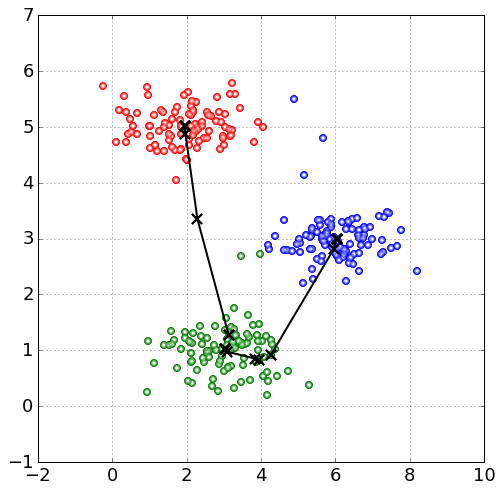

In [17]:
run_kmeans(X, initial_centroids, max_iters=10, display_progress=True)
plt.show()

### 1.4 Image compression with K-means

<img src="fig2.png" width=400/>

In this exercise, you will apply K-means to image compression. In a straightforward 24-bit color representation of an image, each pixel is represented as three 8-bit unsigned integers (ranging from 0 to 255) that specify the red, green and blue intensity values. This encoding is often refered to as the RGB encoding. Our image contains thousands of colors, and in this part of the exercise, you will reduce the number of colors to 16 colors.

By making this reduction, it is possible to represent (compress) the photo in an efficient way. Specifically, you only need to store the RGB values of the 16 selected colors, and for each pixel in the image you now need to only store the index of the color at that location (where only 4 bits are necessary to represent 16 possibilities).

In this exercise, you will use the K-means algorithm to select the 16 colors that will be used to represent the compressed image. Concretely, you will treat every pixel in the original image as a data example and use the K-means algorithm to find the 16 colors that best group (cluster) the pixels in the 3-dimensional RGB space. Once you have computed the cluster centroids on the image, you will then use the 16 colors to replace the pixels in the original image.

#### 1.4.1 K-means on pixels

In Octave/MATLAB, images can be read in as follows:

```octave
% Load 128x128 color image (bird small.png)
A = imread('bird small.png');
% You will need to have installed the image package to used
% imread. If you do not have the image package installed, you
% should instead change the following line to
%
% load('bird small.mat'); % Loads the image into the variable A
```

This creates a three-dimensional matrix A whose first two indices identify a pixel position and whose last index represents red, green, or blue. For example, A(50, 33, 3) gives the blue intensity of the pixel at row 50 and column 33.

The code inside `ex7.m` first loads the image, and then reshapes it to create an m × 3 matrix of pixel colors (where m = 16384 = 128 × 128), and calls your K-means function on it.

After finding the top K = 16 colors to represent the image, you can now assign each pixel position to its closest centroid using the `findClosestCentroids` function. This allows you to represent the original image using the centroid assignments of each pixel. Notice that you have significantly reduced the number of bits that are required to describe the image. The original image required 24 bits for each one of the 128×128 pixel locations, resulting in total size of 128 × 128 × 24 = 393, 216 bits. The new representation requires some overhead storage in form of a dictionary of 16 colors, each of which require 24 bits, but the image itself then only requires 4 bits per pixel location. The final number of bits used is therefore 16 × 24 + 128 × 128 × 4 = 65, 920 bits, which corresponds to compressing the original image by about a factor of 6.

Finally, you can view the effects of the compression by reconstructing the image based only on the centroid assignments. Specifically, you can replace each pixel location with the mean of the centroid assigned to it. Figure 3 shows the reconstruction we obtained. Even though the resulting image re- tains most of the characteristics of the original, we also see some compression artifacts.

In [18]:
A = plt.imread('bird_small.png')
A.shape

(128, 128, 3)

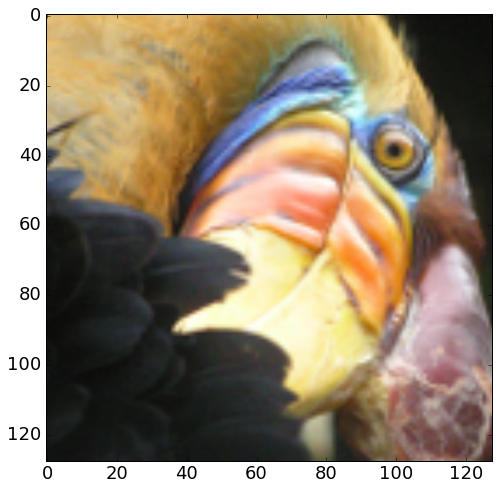

In [19]:
plt.imshow(A)

In [20]:
# normalize so that all values are in the range 0-1
X = A/255.0
X.shape, X[0:2,0:2]

((128, 128, 3), array([[[ 0.003,  0.003,  0.002],
         [ 0.004,  0.003,  0.002]],
 
        [[ 0.004,  0.003,  0.002],
         [ 0.003,  0.003,  0.002]]], dtype=float32))

In [21]:
# Reshape the image into an Nx3 matrix where N = number of pixels.
# Each row will contain the Red, Green and Blue pixel values
# This gives us our dataset matrix X that we will use K-Means on.
X = X.reshape(A.shape[0]*A.shape[1], A.shape[2])
X.shape

(16384, 3)

In [22]:
# Run your K-Means algorithm on this data
# You should try different values of K and max_iters here
K         = 16
max_iters = 10

In [23]:
initial_centroids = init_centroids_kmeans(X, K)
initial_centroids

array([[ 0.004,  0.003,  0.002],
       [ 0.003,  0.002,  0.001],
       [ 0.   ,  0.001,  0.001],
       [ 0.   ,  0.001,  0.   ],
       [ 0.004,  0.002,  0.001],
       [ 0.   ,  0.   ,  0.   ],
       [ 0.004,  0.004,  0.003],
       [ 0.003,  0.003,  0.002],
       [ 0.004,  0.004,  0.003],
       [ 0.002,  0.001,  0.001],
       [ 0.002,  0.002,  0.001],
       [ 0.004,  0.003,  0.003],
       [ 0.   ,  0.   ,  0.   ],
       [ 0.004,  0.003,  0.002],
       [ 0.003,  0.003,  0.002],
       [ 0.001,  0.001,  0.001]], dtype=float32)

In [24]:
centroids, idxs = run_kmeans(X, initial_centroids, max_iters)

K-Means iteration 0/10...
K-Means iteration 1/10...
K-Means iteration 2/10...
K-Means iteration 3/10...
K-Means iteration 4/10...
K-Means iteration 5/10...
K-Means iteration 6/10...
K-Means iteration 7/10...
K-Means iteration 8/10...
K-Means iteration 9/10...


In [25]:
idxs

array([7, 7, 7, ..., 2, 3, 3], dtype=int16)

In [26]:
X_recovered = centroids[idxs, :]
X_recovered.shape

(16384, 3)

In [27]:
# reformulate
A_recovered = X_recovered.reshape(A.shape)*255.0
A_recovered.shape

(128, 128, 3)

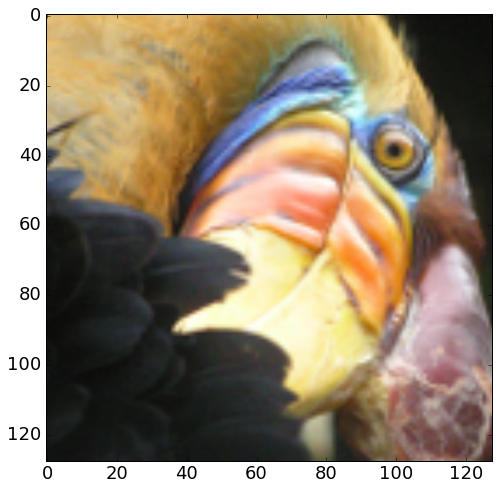

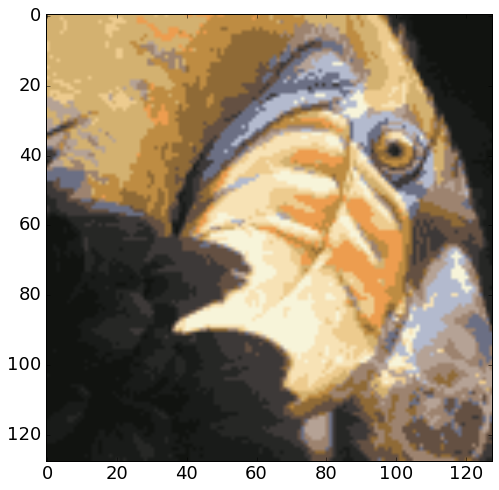

In [28]:
plt.imshow(A)
plt.show()
plt.imshow(A_recovered)
plt.show()

## 2 Principal Component Analysis

In this exercise, you will use principal component analysis (PCA) to perform dimensionality reduction. You will first experiment with an example 2D dataset to get intuition on how PCA works, and then use it on a bigger dataset of 5000 face image dataset.

The provided script, `ex7_pca.m`, will help you step through the first half of the exercise.

### 2.1 Example Dataset

To help you understand how PCA works, you will first start with a 2D dataset which has one direction of large variation and one of smaller variation. The script ex7 pca.m will plot the training data (Figure 4). In this part of the exercise, you will visualize what happens when you use PCA to reduce the data from 2D to 1D. In practice, you might want to reduce data from 256 to 50 dimensions, say; but using lower dimensional data in this example allows us to visualize the algorithms better.

In [29]:
ex7data1 = scipy.io.loadmat('ex7data1.mat')
X        = ex7data1['X']
X.shape

(50, 2)

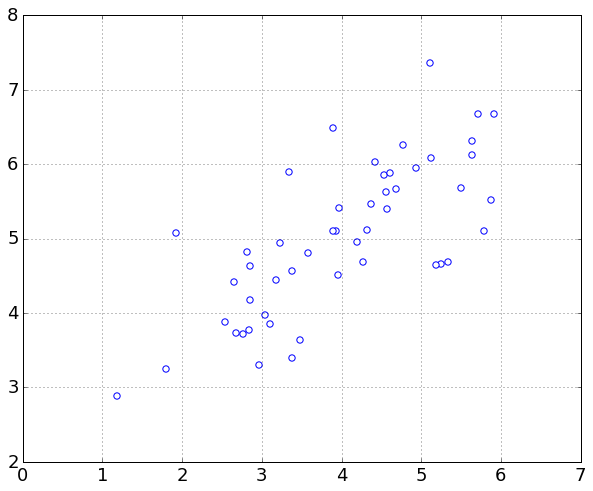

In [30]:
plt.scatter(X[:,0], X[:,1], color='w', edgecolor='b', s=40)
plt.grid()

### 2.2 Implementing PCA

In this part of the exercise, you will implement PCA. PCA consists of two computational steps: First, you compute the covariance matrix of the data. Then, you use Octave/MATLAB’s `SVD` function to compute the eigenvectors $U_1, U_2, \dots , U_n$. These will correspond to the principal components of variation in the data.

Before using PCA, it is important to first normalize the data by subtracting the mean value of each feature from the dataset, and scaling each dimension so that they are in the same range. In the provided script `ex7 pca.m`, this normalization has been performed for you using the `featureNormalize` function.

After normalizing the data, you can run PCA to compute the principal components. You task is to complete the code in `pca.m` to compute the principal components of the dataset. First, you should compute the covariance matrix of the data, which is given by:

\begin{align}
\Sigma = \frac{1}{m}X^T X
\end{align}

where $X$ is the data matrix with examples in rows, and m is the number of examples. Note that $\Sigma$ is a $n \times n$ matrix and not the summation operator.

After computing the covariance matrix, you can run `SVD` on it to compute the principal components. In Octave/MATLAB, you can run `SVD` with the following command: `[U, S, V] = svd(Sigma)`, where `U` will contain the principal components and `S` will contain a diagonal matrix.

<img src="fig5.png" width=500/>

Once you have completed `pca.m`, the `ex7_pca.m` script will run PCA on the example dataset and plot the corresponding principal components found(Figure 5). The script will also output the top principal component (eigenvector) found, and you should expect to see an output of about `[-0.707 -0.707]`. (It is possible that Octave/MATLAB may instead output the negative of this, since $U_1$ and $−U_1$ are equally valid choices for the first principal component.)

In [31]:
def normalize_features(X):
    mu     = np.mean(X, axis=0)
    sigma  = np.std(X, axis=0, ddof=1)
    X_norm = (X - mu)/sigma
    return X_norm, mu, sigma

In [32]:
X_norm, mu, sigma = normalize_features(X)
X_norm[0:5], mu, sigma

(array([[-0.518, -1.577],
        [ 0.459,  0.832],
        [-1.137, -0.577],
        [-1.043, -1.258],
        [-0.974, -0.808]]), array([ 3.989,  5.003]), array([ 1.173,  1.023]))

In [33]:
def pca(X):
    from numpy.linalg import svd
    X       = np.asmatrix(X)
    m, n    = X.shape
    sigma   = (1.0/float(m))*X.T.dot(X)
    U, S, V = svd(sigma)
    U       = np.asarray(U)
    S       = np.asarray(np.diag(S))
    return U, S

In [34]:
U, S = pca(X_norm)
U

array([[-0.707, -0.707],
       [-0.707,  0.707]])

In [35]:
S

array([[ 1.701,  0.   ],
       [ 0.   ,  0.259]])

In [36]:
print("top eigenvectors: "+ str(U[0,:]))

top eigenvectors: [-0.707 -0.707]


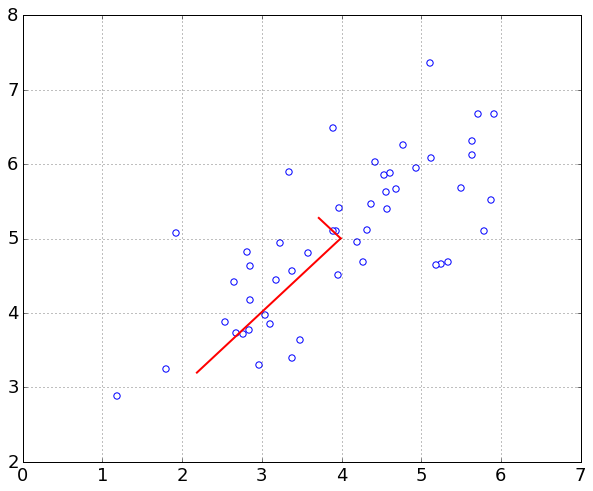

In [37]:
from matplotlib import pyplot, cm, colors, lines

mu1 = mu + 1.5 * S[0,0] * U[:, 0]
mu2 = mu + 1.5 * S[1,1] * U[:, 1]

plt.scatter(X[:,0], X[:,1], color='w', edgecolor='b', s=40)
pyplot.gca().add_line( lines.Line2D( xdata=[mu[0], mu1[0]], ydata=[mu[1], mu1[1]], c='r', lw=2))
pyplot.gca().add_line( lines.Line2D( xdata=[mu[0], mu2[0]], ydata=[mu[1], mu2[1]], c='r', lw=2))
plt.grid()

### 2.3 Dimensionality Reduciton with PCA

After computing the principal components, you can use them to reduce the feature dimension of your dataset by projecting each example onto a lower dimensional space, $x^{(i)} \rightarrow z^{(i)}$ (e.g., projecting the data from 2D to 1D). In this part of the exercise, you will use the eigenvectors returned by PCA and project the example dataset into a 1-dimensional space.

In practice, if you were using a learning algorithm such as linear regression or perhaps neural networks, you could now use the projected data instead of the original data. By using the projected data, you can train your model faster as there are less dimensions in the input.

#### 2.3.1 Projecting the data onto the principal components

You should now complete the code in `projectData.m`. Specifically, you are given a dataset $X$, the principal components U, and the desired number of dimensions to reduce to $K$. You should project each example in $X$ onto the top $K$ components in $U$. Note that the top $K$ components in $U$ are given by the first $K$ columns of $U$, that is `U_`reduce = U(:, 1:K)`.

Once you have completed the code in `projectData.m`, `ex7_pca.m` will project the first example onto the first dimension and you should see a value of about `1.481` (or possibly `-1.481`, if you got $−U_1$ instead of $U_1$).

Recall:

\begin{align}
Z = U_{reduce}^T X
\end{align}

where $U_{reduce} = U_{1 \dots m,1\dots k}$

In [38]:
def project_data(X, U, K):
    U = np.asmatrix(U)
    X = np.asmatrix(X)
    
    U_reduced = U[...,0:K]
    Z = X*U_reduced
    Z = np.asarray(Z)
    return Z

In [39]:
K = 1
Z = project_data(X_norm, U, K)
Z.shape

(50, 1)

In [40]:
Z[0]

array([ 1.481])

#### 2.3.2  Reconstructing an approximation of the data

After projecting the data onto the lower dimensional space, you can approximately recover the data by projecting them back onto the original high dimensional space. Your task is to complete `recoverData.m` to project each example in $Z$ back onto the original space and return the recovered approxi mation in X rec.

Once you have completed the code in `recoverData.m`, `ex7 pca.m` will recover an approximation of the first example and you should see a value of about `[-1.047 -1.047]`.

Recall:

\begin{align}
X_{approx} = U_{reduce} Z
\end{align}

In [41]:
def recover_data(Z, U, K):
    U = np.asmatrix(U)
    Z = np.asmatrix(Z)
    
    U_reduced = U[...,0:K]
    X_rec     = Z*U_reduced.T
    X_rec     = np.asarray(X_rec)
    return X_rec

In [42]:
X_rec = recover_data(Z, U, K)
X_rec.shape

(50, 2)

In [43]:
X_rec[0]

array([-1.047, -1.047])

#### 2.3.3 Visualizing the Projections

After completing both `projectData` and `recoverData`, `ex7_pca.m` will now perform both the projection and approximate reconstruction to show how the projection affects the data. In Figure 6, the original data points are indicated with the blue circles, while the projected data points are indicated with the red circles. The projection effectively only retains the information in the direction given by $U_1$.

<img src="fig5.png" width=500/>

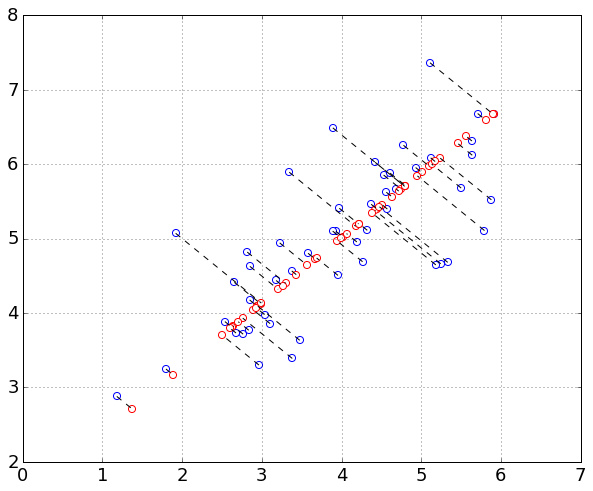

In [44]:
from matplotlib import pyplot, cm, colors, lines

X_approx = (X_rec*sigma)+mu

plt.scatter(X[:,0], X[:,1], color='w', edgecolor='b', s=50)
plt.scatter(X_approx[:,0], X_approx[:,1], color='w', edgecolor='r', s=50)

m, n = X.shape
for i in range(m):
    plt.gca().add_line(
        lines.Line2D(
            xdata = [X[i,0], X_approx[i,0]],
            ydata = [X[i,1], X_approx[i,1]],
            c     = 'k',
            lw    = '1',
            ls    = '--',
        )
    )
plt.grid()

### 2.4 Face Image Dataset

In this part of the exercise, you will run PCA on face images to see how it can be used in practice for dimension reduction. The dataset `ex7faces.mat` contains a dataset `X` of face images, each $32 \times 32$ in grayscale. Each row of `X` corresponds to one face image (a row vector of length 1024). The next￼￼￼￼￼￼￼￼￼￼￼￼￼￼￼￼￼￼￼￼￼￼￼￼￼￼￼￼￼￼￼￼￼￼￼￼￼￼￼￼￼￼￼￼￼￼￼￼￼￼￼￼￼￼￼￼￼￼￼￼￼￼￼￼￼￼￼￼￼￼￼￼￼￼￼￼￼￼￼￼￼￼￼￼￼￼￼￼￼￼￼￼￼￼￼￼￼￼￼￼￼￼￼￼￼￼￼￼￼￼￼￼￼￼￼￼￼￼￼￼￼￼￼￼￼￼￼￼￼￼￼￼￼￼￼￼￼￼￼￼￼￼￼￼￼￼￼￼￼￼￼￼￼￼￼￼￼￼￼￼￼￼￼￼￼￼￼￼￼￼￼￼￼￼￼￼￼￼￼￼￼￼ step in `ex7_pca.m` will load and visualize the first 100 of these face images.

In [45]:
def display_data(X, w=10, p=32, ax=None, seed=-1):
    m, n  = X.shape
    image = np.zeros((w*p, w*p))
    if seed >= 0:
        random.seed(seed)
    for i in np.arange(w*w):
        row       = int(i//w)
        col       = int(i%w)
        row_begin = row*p
        row_end   = (row+1)*p
        col_begin = col*p
        col_end   = (col+1)*p
        idx       = i if seed < 0 else int(random.uniform(0,m))
        image[row_begin:row_end,:][:,col_begin:col_end] = X[idx].reshape(p,p).T

    if ax is None:
        ax = plt.subplot()
    ax.imshow(image).set_cmap( 'gray' )
    ax.axis('off')

In [46]:
ex7faces = scipy.io.loadmat('ex7faces.mat')
X        = ex7faces['X']
X.shape

(5000, 1024)

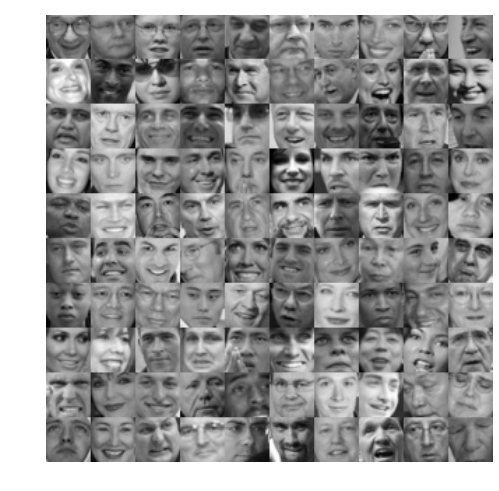

In [47]:
display_data(X)

#### 2.4.1 PCA on Faces

To run PCA on the face dataset, we first normalize the dataset by subtracting the mean of each feature from the data matrix $X$. The script `ex7_pca.m` will do this for you and then run your PCA code. After running PCA, you will obtain the principal components of the dataset. Notice that each principal component in $U$ (each row) is a vector of length $n$ (where for the face dataset, $n = 1024$). It turns out that we can visualize these principal components by reshaping each of them into a $32 \times 32$ matrix that corresponds to the pixels in the original dataset. The script `ex7_pca.m` displays the first 36 principal components that describe the largest variations (Figure 8). If you want, you can also change the code to display more principal components to see how they capture more and more details.

<img src="fig8.png" width=500/>

In [48]:
X_norm, mu, sigma = normalize_features(X)
X_norm.shape, mu.shape, sigma.shape

((5000, 1024), (1024,), (1024,))

In [49]:
U, S = pca(X_norm)
U.shape, S.shape

((1024, 1024), (1024, 1024))

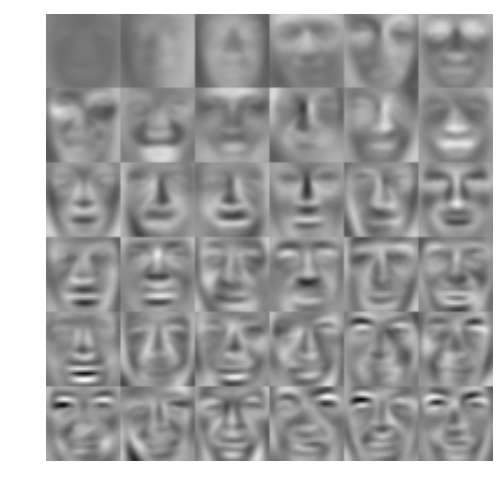

In [50]:
display_data(U[:,0:36].T, w=6)

#### 2.4.2 Dimensionality Reduction

Now that you have computed the principal components for the face dataset, you can use it to reduce the dimension of the face dataset. This allows you to use your learning algorithm with a smaller input size (e.g., 100 dimensions) instead of the original 1024 dimensions. This can help speed up your learning algorithm.

The next part in `ex7_pca.m` will project the face dataset onto only the first 100 principal components. Concretely, each face image is now described by a vector $z^{(i)} \in \Bbb{R}^{100}$.

To understand what is lost in the dimension reduction, you can recover the data using only the projected dataset. In `ex7_pca.m`, an approximate recovery of the data is performed and the original and projected face images are displayed side by side (Figure 9). From the reconstruction, you can observe that the general structure and appearance of the face are kept while the fine details are lost. This is a remarkable reduction (more than $10\times$) in the dataset size that can help speed up your learning algorithm significantly. For example, if you were training a neural network to perform person recognition (gven a face image, predict the identitfy of the person), you can use the dimension reduced input of only a 100 dimensions instead of the original pixels.

<img src="fig9.png" width=900/>

In [51]:
K = 100
Z = project_data(X_norm, U, K)
Z.shape

(5000, 100)

In [52]:
X_rec = recover_data(Z, U, K)
X_rec.shape

(5000, 1024)

In [53]:
X_approx = (X_rec*sigma) + mu

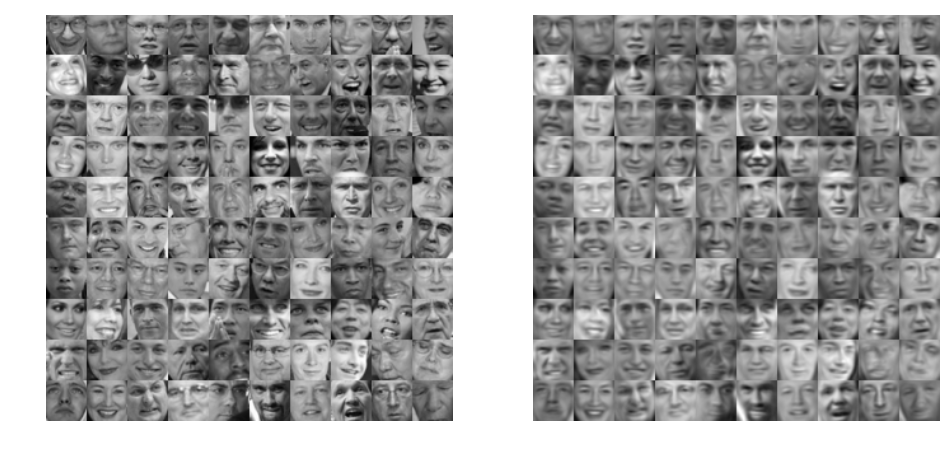

In [54]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16,8))
display_data(X       , ax=ax1)
display_data(X_approx, ax=ax2)

### 2.5 PCA for visualization

<img src="fig10.png" width=500/>

In the earlier K-means image compression exercise, you used the K-means algorithm in the 3-dimensional RGB space. In the last part of the `ex7_pca.m` script, we have provided code to visualize the final pixel assignments in this 3D space using the `scatter3` function. Each data point is colored according to the cluster it has been assigned to. You can drag your mouse on the figure to rotate and inspect this data in 3 dimensions.

It turns out that visualizing datasets in 3 dimensions or greater can be cumbersome. Therefore, it is often desirable to only display the data in 2D even at the cost of losing some information. In practice, PCA is often used to reduce the dimensionality of data for visualization purposes. In the next part of `ex7_pca.m`, the script will apply your implementation of PCA to the 3-dimensional data to reduce it to 2 dimensions and visualize the result in a 2D scatter plot. The PCA projection can be thought of as a rotation that selects the view that maximizes the spread of the data, which often corresponds to the “best” view.

<img src="fig11.png" width=500/>

In [55]:
A = plt.imread('bird_small.png')
A.shape

(128, 128, 3)

In [56]:
X = (A/255.0).reshape(A.shape[0]*A.shape[1], 3)
X.shape

(16384, 3)

In [58]:
K         = 16
max_iters = 10
initial_centroids = init_centroids_kmeans(X, K)
centroids, idxs   = run_kmeans(X, initial_centroids, max_iters, display_progress=False)

K-Means iteration 0/10...
K-Means iteration 1/10...
K-Means iteration 2/10...
K-Means iteration 3/10...
K-Means iteration 4/10...
K-Means iteration 5/10...
K-Means iteration 6/10...
K-Means iteration 7/10...
K-Means iteration 8/10...
K-Means iteration 9/10...


In [59]:
seed = 1
np.random.seed(seed)
m, n  = X.shape
sel   = np.random.choice(np.arange(m), 1000)
X_sel = X[sel,...]
X_sel.shape

(1000, 3)

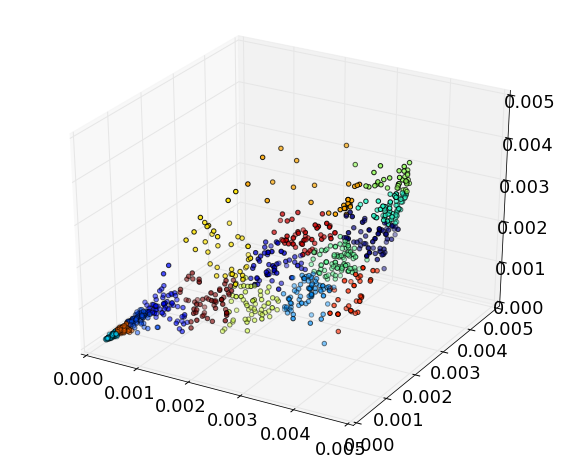

In [60]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax  = fig.add_subplot(111, projection='3d')
ax.scatter(X_sel[...,0], X_sel[...,1], X_sel[...,2], c=idxs[sel], marker='o')
ax.set_xlim3d(0, 0.005)
ax.set_ylim3d(0, 0.005)
ax.set_zlim3d(0, 0.005)
plt.show()

In [61]:
X_norm, mu, sigma = normalize_features(X)
X_norm.shape, mu.shape, sigma.shape

((16384, 3), (3,), (3,))

In [62]:
U, S = pca(X_norm)
U.shape, S.shape

((3, 3), (3, 3))

In [63]:
Z = project_data(X_norm, U, K=2)
Z.shape

(16384, 2)

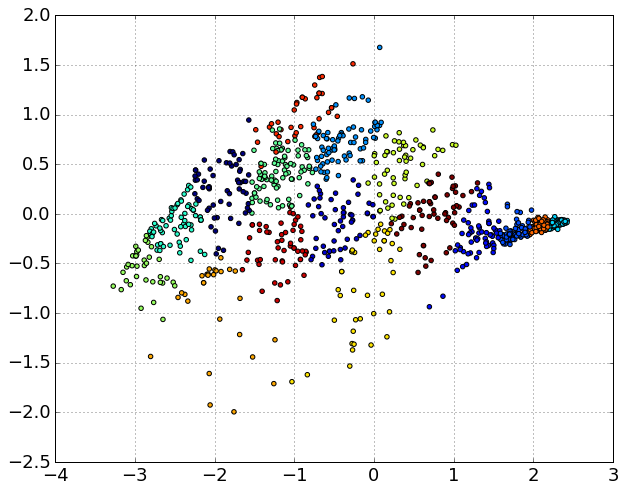

In [64]:
plt.scatter(Z[sel,0], Z[sel,1], c=idxs[sel], marker='o')
plt.grid()
plt.show()